In [1]:
#For numerics
import numpy as np

#For loading and saving data
import pandas as pd

#For plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

#For TeX plots
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

#For colorblind plots
import seaborn
colors = list(seaborn.color_palette('colorblind').as_hex())

#
import itertools

#For setting root path and accessing files
import sys
import os
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root not in sys.path:
    sys.path.append(root)
os.chdir('..') 
import h5py

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

#for caching cross-section values
from functools import lru_cache

from lepton_nucleus_collisions.limits import EIC_limit, MuSIC_limit, MuBeD_limit
from lfv_lepton_observables.limits import (magnetic_dipole_moment_limit, 
                                           g_2_explanation,
                                           radiative_processes,
                                           radiative_decay_limit,
                                           trilepton_processes,
                                           trilepton_decay_limit)
from lfv_higgs_decays.limits import Cll_limit
from lfv_higgs_decays.formulae.higgs_decay_signals import ta_to_Cij
from phys.constants import me, mm, mt

In [2]:
def plot_Higgs_decay_limits(ma, ij, Cah, ax = None, which = 'Cah', Cll = [[1]*3]*3):

    if not ax:
        ax = plt.gca()
    
    ############# Constraints ##############

    Cll_limits = Cll_limit(ma, Cah,
                           ij = ij,
                           which = which,
                           Cll_range = (1e-6, 1e2),
                           npts = 400,
                           detector = ['ATLAS', 'CMS'],
                           Cll = Cll
                          )

    ############# Projections ##############

    Cll_projections = Cll_limit(ma, Cah,
                                which = which,
                                ij = ij,
                                Cll_range = (1e-10, 1e2),
                                npts = 400,
                                detector = ['CMS', 'ATLAS', 'MATHUSLA'],
                                projection = True,
                                Cll = Cll
                              )

    #Projections
    for limit in Cll_projections:
        ax.plot(*limit, color = 'black', dashes = (8, 8), linewidth = 0.5)
        ax.fill(*limit, color = 'grey' , alpha = 0.075)

    #CMS
    for limit in Cll_limits:
        ax.fill(*limit, color = 'grey', edgecolor = 'black', alpha = 0.6)

    ax.tick_params(which = 'both', direction = 'in', labelsize = 12)
    ax.set_xlim(0, 62.5)
    ax.set_xlabel('$m_a~[{\\rm GeV}]$', fontsize = 14)
    ax.set_ylim(1e-9, 1e2)
    ax.set_yscale('log')
    ax.set_ylabel('$C_{\\tau \\ell}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 14)
    return ax

def lepton_decay_limits(ma, ij, Cll = np.ones((3, 3)), mode = 'PC', CL = 0.95, which = 'radiative'):

    # By default, limit is 90% confidence. Limit is proportional to
    # (90% upper bound on decay rate)^{1/4}. For a Poisson counting
    # experiment with zero observed events, the upper bound on the
    # mean is proportional to -log(1 - confidence). 
    # In practice, this will barely change anything. For example.
    # (log(1 - 0.95)/log(1 - 0.9))^(1/4) = 1.068
    
    z_score_conf = -np.log(1-CL)
    z_score_90 = -np.log(0.1)
    factor = (z_score_conf/z_score_90)**(1/4)
    
    limit = {}
    if which == 'radiative':
        for process in radiative_processes:
            limit[process] = factor*radiative_decay_limit(ma, process, ij+ij, g = Cll, mode = mode, ALP = True)
    elif which == 'trilepton':
        for process in trilepton_processes:
            limit[process] = factor*trilepton_decay_limit(ma, process, ij+ij, g = Cll, mode = mode, ALP = True)
    return limit
    
def plot_lepton_observable_limits(ma, ij, ax = None, Cll = np.ones((3,3)),
                                  color = colors[8], plot_lines = False,
                                  include_dipole = False,
                                  radiative_color = colors[3],
                                  trilepton_color = colors[4],
                                  dipole_color = colors[5]):
    
    if not ax:
        ax = plt.gca()
        
    PC_radiative_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'PC', which = 'radiative').values())
    PC_trilepton_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'PC', which = 'trilepton').values())
    PC_limits = PC_radiative_limits+PC_trilepton_limits
    if include_dipole:
        PC_dipole_limits = list(lepton_dipole_limits(ma, ij, Cll = Cll, mode = 'PC').values())
        PC_limits = PC_limits + PC_dipole_limits
        
    chiral_radiative_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'chiral', which = 'radiative').values())
    chiral_trilepton_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'chiral', which = 'trilepton').values())
    chiral_limits = chiral_radiative_limits+chiral_trilepton_limits
    if include_dipole:
        chiral_dipole_limits = list(lepton_dipole_limits(ma, ij, Cll = Cll, mode = 'chiral').values())
        chiral_limits = chiral_limits + chiral_dipole_limits
    
    absolute_chi_limit = np.nanmin(chiral_limits, axis = 0)
    absolute_PC_limit = np.nanmin(PC_limits, axis = 0)
    absolute_limit = np.nanmin(PC_limits+chiral_limits, axis = 0)
    
    ax.fill_between(ma, absolute_limit, 1e8, color = color, alpha = 0.1)
    ax.plot(ma, absolute_chi_limit, color = 'black', linewidth = 0.5, dashes = (4, 8))
    ax.plot(ma, absolute_PC_limit,color = 'black', linewidth = 0.5)
    ax.plot(ma, absolute_limit, color = 'black', linewidth = 0.5)
    
    if plot_lines:
        for chi, PC in zip(chiral_radiative_limits, PC_radiative_limits):
            ax.plot(ma, PC, color = radiative_color, linewidth = 0.5)
            ax.plot(ma, chi, color = radiative_color, linestyle = 'dashed', linewidth = 0.5)
        for chi, PC in zip(chiral_trilepton_limits, PC_trilepton_limits):
            ax.plot(ma, PC, color = trilepton_color, linewidth = 0.5)
            ax.plot(ma, chi, color = trilepton_color, linestyle = 'dashed', linewidth = 0.5)
        if include_dipole:
            for chi, PC in zip(chiral_dipole_limits, PC_dipole_limits):
                ax.plot(ma, PC, color = dipole_color, linewidth = 0.5)
                ax.plot(ma, chi, color = dipole_color, linestyle = 'dashed', linewidth = 0.5)
    return ax

In [3]:
def plot_all_limits(ma, ij, Cah, ax = None, which = 'Cahp', Cll = [[1]*3]*3):

    if not ax:
        ax = plt.gca()
    
    #LFV lepton decay limits (color yellow)
    plot_lepton_observable_limits(ma, ij, ax = ax, Cll = Cll)
    
    #Higgs decay limits (color grey)
    plot_Higgs_decay_limits(ma, ij, Cah, ax = None, which = which, Cll = Cll)

    #Lepton-Nucleus Collision limits
    #EIC
    EIC_conservative = EIC_limit(ma, idx = ij, g = Cll, ALP = True)
    EIC_optimistic = EIC_limit(ma, idx = ij, tau_efficiency = 0.15, g = Cll, ALP = True)

    if np.any(~np.isnan(EIC_conservative)):
        plt.plot(ma, EIC_conservative,
                 color = colors[0],
                 linewidth = 3)
        idx_cons = np.min(np.where(~np.isnan(EIC_conservative))[0])
        plt.plot([ma[idx_cons], ma[idx_cons]],
                 [EIC_conservative[idx_cons], 1e8],
                 color = colors[0],
                 linewidth = 3)

    if np.any(~np.isnan(EIC_optimistic)):
        plt.plot(ma, EIC_optimistic,
                 color = colors[0],
                 linestyle = 'dashed')
        idx_opt = np.min(np.where(~np.isnan(EIC_optimistic))[0])
        plt.plot([ma[idx_opt], ma[idx_cons]],
                 [EIC_optimistic[idx_opt], EIC_conservative[idx_cons]],
                 color = colors[0],
                 linestyle = 'dashed')

    #MuBeD
    MuBeD_conservative = MuBeD_limit(ma, idx = ij, g = Cll, ALP = True)
    MuBeD_optimistic = MuBeD_limit(ma, idx = ij, N_MOT=1e18, g = Cll, ALP = True)
    
    if np.any(~np.isnan(MuBeD_conservative)):
        plt.plot(ma, MuBeD_conservative,
                 color = colors[3],
                 linewidth = 3)
        idx_cons = np.min(np.where(~np.isnan(MuBeD_conservative))[0])
        plt.plot([ma[idx_cons], ma[idx_cons]],
                 [MuBeD_conservative[idx_cons], 1e8],
                 color = colors[3],
                 linewidth = 3)
        
    if np.any(~np.isnan(MuBeD_optimistic)):
        plt.plot(ma, MuBeD_optimistic,
                 color = colors[3],
                 linestyle = 'dashed')
        idx_opt = np.min(np.where(~np.isnan(MuBeD_optimistic))[0])
        plt.plot([ma[idx_opt], ma[idx_cons]],
                 [MuBeD_optimistic[idx_opt], MuBeD_conservative[idx_cons]],
                 color = colors[3],
                 linestyle = 'dashed')
    
    #MuSIC
    MuSIC_conservative = MuSIC_limit(ma, idx = ij, tau_efficiency = 0.01, g = Cll, ALP = True)
    MuSIC_optimistic = MuSIC_limit(ma, idx = ij, tau_efficiency = 0.15, g = Cll, ALP = True)

    if np.any(~np.isnan(MuSIC_conservative)):
        plt.plot(ma, MuSIC_conservative,
                 color = colors[2],
                 linewidth = 3)
        idx_cons = np.min(np.where(~np.isnan(MuSIC_conservative))[0])
        plt.plot([ma[idx_cons], ma[idx_cons]],
                 [MuSIC_conservative[idx_cons], 1e8],
                 color = colors[2],
                 linewidth = 3)
        
    if np.any(~np.isnan(MuSIC_optimistic)):
        plt.plot(ma, MuSIC_optimistic,
                 color = colors[2],
                 linestyle = 'dashed')
        idx_opt = np.min(np.where(~np.isnan(MuSIC_optimistic))[0])
        plt.plot([ma[idx_opt], ma[idx_cons]],
                 [MuSIC_optimistic[idx_opt], MuSIC_conservative[idx_cons]],
                 color = colors[2],
                 linestyle = 'dashed')

    return ax

(0.0, 20.0)

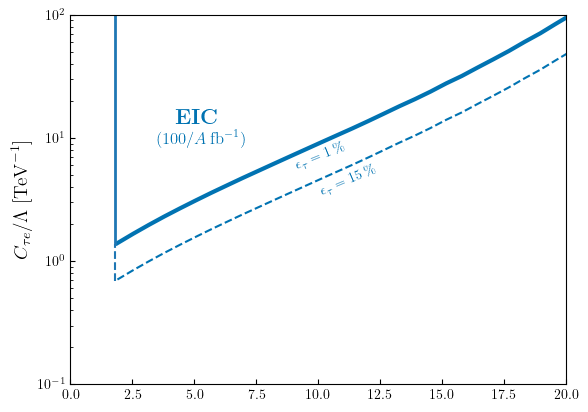

In [4]:
#plot_dipole_limits((0, 2))

Cll = [[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0]]
masses = np.linspace(0, 62.5, 100)

EIC_conservative = EIC_limit(masses,
                             electron_loss_rate = 1e-2,
                             g = Cll,
                             ALP = True)

plt.plot(masses, EIC_conservative, 100, color = colors[0], linewidth = 3)

eic_limit = EIC_limit(masses,
                      electron_loss_rate = 1e-2,
                      electron_positron_misID_rate = 1e-3,
                      tau_efficiency = 0.15,
                      g = Cll, 
                      ALP = True)


plt.plot(masses, eic_limit, 100, color = colors[0], linestyle = 'dashed')
plt.axvline(1.8, 0.38, 1, linewidth = 2)
plt.axvline(1.8, 0.28, 0.38, linestyle = 'dashed')


plt.text(4.2, 13, '${\\bf EIC}$', color = colors[0], fontsize = 16)
plt.text(3.5, 9, '$(100/A~{\\rm fb}^{-1})$', color = colors[0], fontsize = 12)

plt.text(10, 3.4, '$\\epsilon_\\tau = 15~\\%$', rotation = 23, color = colors[0])
plt.text(9, 5.5, '$\\epsilon_\\tau = 1~\\%$', rotation = 22, color = colors[0])

plt.ylabel('$C_{\\tau e}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 14)
plt.tick_params(which = 'both', direction = 'in') 


plt.yscale('log')
plt.ylim(1e-1, 1e2)
plt.xlim(0, 20)

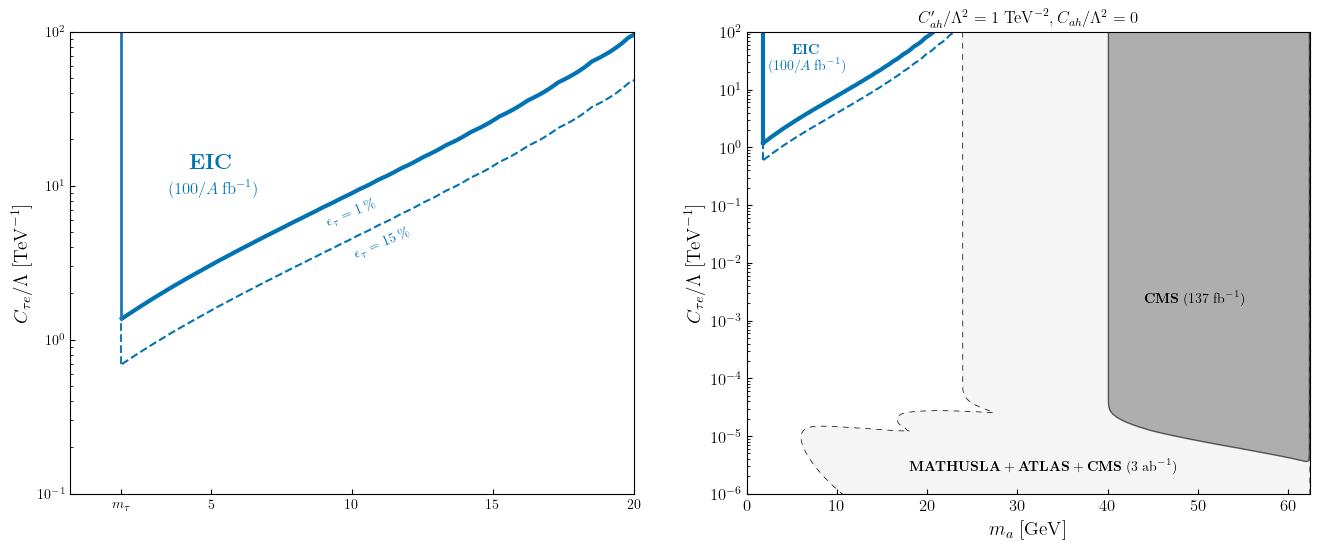

In [24]:
Cll = [[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0]]
ij = (0, 2)

masses = np.linspace(1.7, 62.5, 1000)

fig = plt.figure(figsize = (16, 6))
gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

EIC_conservative = EIC_limit(masses,
                             electron_loss_rate = 1e-2,
                             g = Cll,
                             ALP = True)

plt.plot(masses, EIC_conservative, 100, color = colors[0], linewidth = 3)

EIC_optimistic = EIC_limit(masses,
                           electron_loss_rate = 1e-2,
                           electron_positron_misID_rate = 1e-3,
                           tau_efficiency = 0.15,
                           g = Cll, 
                           ALP = True)


plt.plot(masses, EIC_optimistic, 100, color = colors[0], linestyle = 'dashed')
plt.axvline(1.8, 0.38, 1, linewidth = 2)
plt.axvline(1.8, 0.28, 0.38, linestyle = 'dashed')


plt.text(4.2, 13, '${\\bf EIC}$', color = colors[0], fontsize = 16)
plt.text(3.5, 9, '$(100/A~{\\rm fb}^{-1})$', color = colors[0], fontsize = 12)

plt.text(10, 3.4, '$\\epsilon_\\tau = 15~\\%$', rotation = 23, color = colors[0])
plt.text(9, 5.5, '$\\epsilon_\\tau = 1~\\%$', rotation = 22, color = colors[0])

plt.ylabel('$C_{\\tau e}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 14)
plt.tick_params(which = 'both', direction = 'in') 

plt.yscale('log')
plt.ylim(1e-1, 1e2)
plt.xlim(0, 20)

plt.xticks([1.777] + [5*i for i in range(1, 5)], ['$m_\\tau$'] + [f'${5*i}$' for i in range(1, 5)])

ax2 = fig.add_subplot(gs[1])

plot_all_limits(masses, ij, 1, Cll = Cll)

plt.text(5, 42, '${\\bf EIC}$', color = colors[0], fontsize = 10)
plt.text(2.5, 22, '$(100/A~{\\rm fb}^{-1})$', color = colors[0], fontsize = 10)
plt.text(44, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 10)
plt.text(18, 2.5e-6, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 10)

plt.ylabel('$C_{\\tau e}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 14)

plt.yscale('log')
plt.ylim(1e-6, 1e2)
plt.xlim(0, 62.5)

plt.title('$C_{ah}^\\prime/\\Lambda^2 = 1~{\\rm TeV}^{-2}, C_{ah}/\\Lambda^2 = 0$')

plt.savefig('figures/chapter5/EIC_ALP_limits.pdf', format = 'pdf')

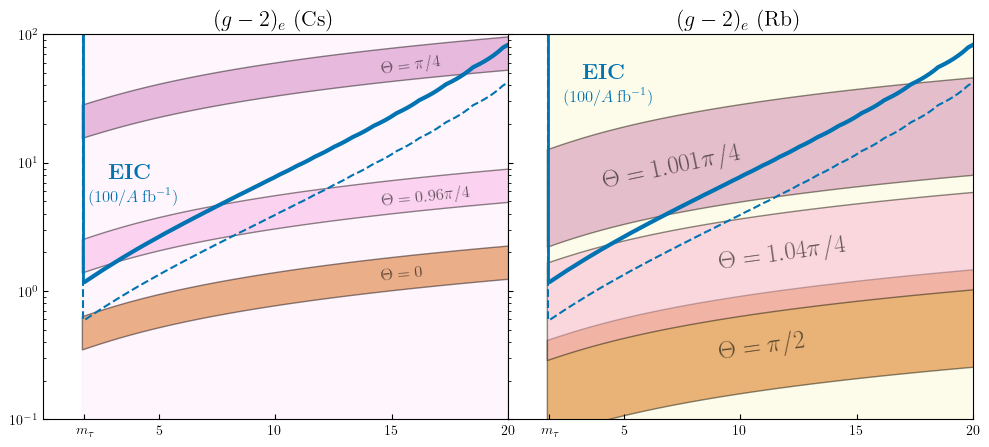

In [25]:
Cll = [[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0]]

fig = plt.figure(figsize = (12, 5))
gs = GridSpec(1, 2, wspace = 0)

ax1 = fig.add_subplot(gs[0]) 

ax1.plot(masses, EIC_limit(masses, g = Cll, ALP = True), color = colors[0], linewidth = 3)
ax1.plot(masses, EIC_limit(masses, g = Cll, tau_efficiency = 0.15, ALP = True), color = colors[0], linestyle = 'dashed')

ax1.fill_between(masses, *g_2_explanation(masses, 'e Cs', (0, 2), th = 0*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[3], edgecolor = 'black')
ax1.fill_between(masses, *g_2_explanation(masses, 'e Cs', (0, 2), th = 0.96*np.pi/4*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[6], edgecolor = 'black')
ax1.fill_between(masses, *g_2_explanation(masses, 'e Cs', (0, 2), th = np.pi/4*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[4], edgecolor = 'black')

ax1.fill_between(masses, 1e-1, 1e2, color = colors[6], alpha = 0.1)

ax1.axvline(1.74, 0.36, 1, color = colors[0], linewidth = 2)
ax1.axvline(1.74, 0.26, 1, color = colors[0], linestyle = 'dashed')

ax1.text(14.5, 50, '$\\Theta = \\pi/4$', rotation = 8, fontsize = 12, alpha = 0.6)
ax1.text(14.5, 4.7, '$\\Theta = 0.96\\pi/4$', rotation = 6, fontsize = 12, alpha = 0.6)
ax1.text(14.5, 1.2, '$\\Theta = 0$', rotation = 6, fontsize = 12, alpha = 0.6)

ax1.text(2.8, 7.6, '${\\bf EIC}$', fontsize = 16, color = colors[0])
ax1.text(2., 5, '$(100/A~{\\rm fb}^{-1})$', fontsize = 12, color = colors[0])

ax1.set_title('$(g-2)_e~({\\rm Cs})$', fontsize = 16)

ax1.set_xticks([1.777] + [5*i for i in range(1, 5)], ['$m_\\tau$'] + [f'${5*i}$' for i in range(1, 5)])
ax1.tick_params(which = 'both', direction = 'in')

ax1.set_yscale('log')
ax1.set_ylim(1e-1, 1e2)
ax1.set_xlim(0, 20)

ax2 = fig.add_subplot(gs[1])

ax2.plot(masses, EIC_limit(masses, g = Cll, ALP = True), color = colors[0], linewidth = 3)
ax2.plot(masses, EIC_limit(masses, g = Cll, tau_efficiency = 0.15, ALP = True), color = colors[0], linestyle = 'dashed')

ax2.fill_between(masses, *g_2_explanation(masses, 'e Rb', (0, 2), th = np.pi/2*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[3], edgecolor = 'black')
ax2.fill_between(masses, *g_2_explanation(masses, 'e Rb', (0, 2), th = 1.04*np.pi/4*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[6], edgecolor = 'black')
ax2.fill_between(masses, *g_2_explanation(masses, 'e Rb', (0, 2), th = 1.001*np.pi/4*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[4], edgecolor = 'black')


ax2.fill_between(masses, 1e-1, 1e2, color = colors[8], alpha = 0.1)

ax2.axvline(1.74, 0.36, 1, color = colors[0], linewidth = 2)
ax2.axvline(1.74, 0.26, 1, color = colors[0], linestyle = 'dashed')

ax2.text(4, 6.5, '$\\Theta = 1.001\\pi/4$', rotation = 12, fontsize = 18, alpha = 0.6)
ax2.text(9, 1.5, '$\\Theta = 1.04\\pi/4$', rotation = 8, fontsize = 18, alpha = 0.6)
ax2.text(9, 0.3, '$\\Theta = \\pi/2$', rotation = 8, fontsize = 18, alpha = 0.6)

ax2.text(3.2, 45.6, '${\\bf EIC}$', fontsize = 16, color = colors[0])
ax2.text(2.4, 30, '$(100/A~{\\rm fb}^{-1})$', fontsize = 12, color = colors[0])

ax2.set_title('$(g-2)_e~({\\rm Rb})$', fontsize = 16)

ax2.set_xticks([1.777] + [5*i for i in range(1, 5)], ['$m_\\tau$'] + [f'${5*i}$' for i in range(1, 5)])
ax2.tick_params(which = 'both', direction = 'in', labelleft = False)

ax2.set_yscale('log')
ax2.set_ylim(1e-1, 1e2)
ax2.set_xlim(0, 20)

plt.savefig('figures/chapter5/EIC_ALP_electron_g_2.pdf', format = 'pdf')

In [7]:
from skimage import measure

def find_contours(x, y, Z, Z_val = 1):
    contours = measure.find_contours(Z, Z_val)

    boundary_pts = []
    for cont in contours:
        i, j = cont.T[0], cont.T[1]  # Extract row/col indices
        x_coords = np.interp(i, np.arange(len(x)), x)  # Map cols to x
        y_coords = np.interp(j, np.arange(len(y)), y)  # Map rows to y
        boundary_pts.append(np.column_stack((x_coords, y_coords)).T)
    
    return boundary_pts

In [27]:
Cll = [[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0]]

theta = np.linspace(0.4, 1, 10000)
theta_mat = theta.reshape(1, 1, 1, -1) * np.ones((3, 3, 1, 1))

masses = np.linspace(0, 25, 1000)

Cs_explanation = g_2_explanation(masses.reshape(-1, 1), 'e Cs', (2, 0), g = np.array(Cll).reshape(3, 3, 1, 1).repeat(10000, axis = 3), th = theta_mat, ALP = True)
Cs_avg = np.mean(Cs_explanation, axis = 0)

Rb_explanation = g_2_explanation(masses.reshape(-1, 1), 'e Rb', (2, 0), g = np.array(Cll).reshape(3, 3, 1, 1).repeat(10000, axis = 3), th = theta_mat, ALP = True)
Rb_avg = np.mean(Rb_explanation, axis = 0)
get_EIC = EIC_limit(masses, g = Cll, tau_efficiency = 0.01, ALP = True).reshape(-1, 1)
get_EIC_opt = EIC_limit(masses, g = Cll, tau_efficiency = 0.15, ALP = True).reshape(-1, 1)

#We want those values of m and theta for which g_explanation > g_EIC_lim

Cs_line = find_contours(masses, theta, (Cs_avg - get_EIC), 0)[0]
Rb_line = find_contours(masses, theta, (Rb_avg - get_EIC), 0)[0]

Cs_line_opt = find_contours(masses, theta, (Cs_avg - get_EIC_opt), 0)[0]
Rb_line_opt = find_contours(masses, theta, (Rb_avg - get_EIC_opt), 0)[0]

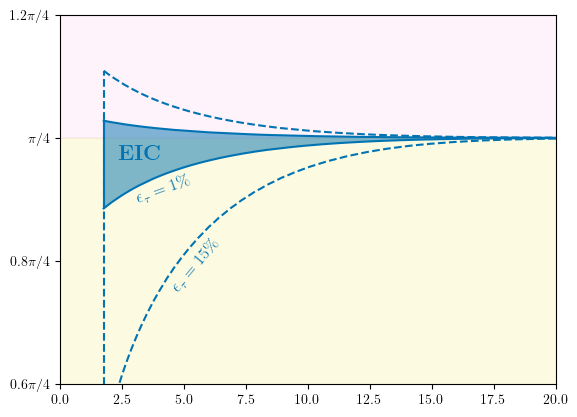

In [28]:
plt.fill_between(masses, 0.1*np.pi, np.pi/4-me/mt, color = colors[8], alpha = 0.15)
plt.fill_between(masses, np.pi/4-me/mt, 1.3*np.pi, color = colors[6], alpha = 0.15)

plt.fill_between(*Cs_line, np.pi/4, color = colors[0], alpha = 0.5, edgecolor = None)
plt.fill_between(*Rb_line, np.pi/4, color = colors[0], alpha = 0.5, edgecolor = None)

plt.plot(*Cs_line, color = colors[0])
plt.plot(*Rb_line, color = colors[0])
plt.plot([1.77, 1.77], [Cs_line[1][Cs_line[0].argmin()], Rb_line[1][Rb_line[0].argmin()]], color = colors[0])

plt.plot(*Cs_line_opt, color = colors[0], linestyle = 'dashed')
plt.plot(*Rb_line_opt, color = colors[0], linestyle = 'dashed')
plt.plot([1.77, 1.77], [Cs_line_opt[1][Cs_line_opt[0].argmin()], Rb_line_opt[1][Rb_line_opt[0].argmin()]], color = colors[0], linestyle = 'dashed')

plt.text(2.35, 0.965*np.pi/4, '${\\bf EIC}$', fontsize = 16, color = colors[0])
plt.text(3, 0.895*np.pi/4, '$\\epsilon_\\tau = 1\%$', rotation = 20, fontsize = 12, color = colors[0])
plt.text(4.4, 0.75*np.pi/4, '$\\epsilon_\\tau = 15\%$', rotation = 50, fontsize = 12, color = colors[0])

yticks = np.round(np.array([0.4 + 0.2*i for i in range(6)]), 2)
plt.yticks(yticks*np.pi/4, [f'$\\pi/4$' if tick == 1 else f'${tick}\\pi/4$' for tick in yticks])
plt.ylim(0.6*np.pi/4, 1.2*np.pi/4)
plt.xlim(0, 20)

plt.savefig('figures/chapter5/EIC_g_2_probe.pdf', format = 'pdf')

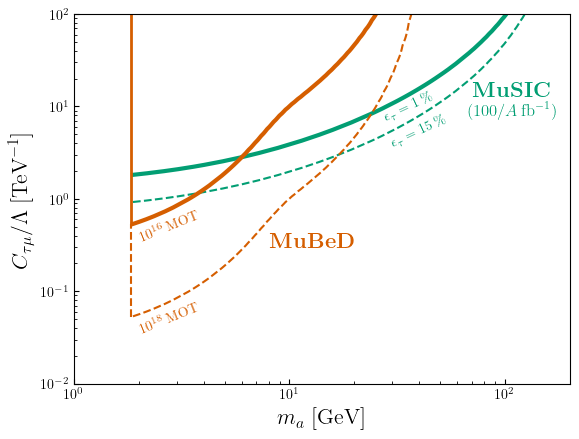

In [10]:
#plot_dipole_limits((0, 2))

Cll = [[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]]
masses = np.geomspace(1e0, 200, 1000)

plt.plot(masses, 
         MuSIC_limit(masses,
                     g = Cll, 
                     tau_efficiency = 0.01, 
                     ALP = True),
         color = colors[2],
         linewidth = 3)

plt.plot(masses, 
         MuSIC_limit(masses,
                     g = Cll, 
                     tau_efficiency = 0.15, 
                     ALP = True),
         color = colors[2],
         linestyle = 'dashed')


plt.plot(masses, 
         MuBeD_limit(masses,
                     g = Cll, 
                     tau_efficiency = 0.15,
                     ALP = True),
         color = colors[3],
         linewidth = 3)
plt.plot(masses, 
         MuBeD_limit(masses,
                     g = Cll, 
                     tau_efficiency = 0.15,
                     N_MOT = 1e18,
                     ALP = True),
         color = colors[3],
         linestyle = 'dashed')

plt.axvline(mt+mm-0.04, 0.432, 1, color = colors[3], linewidth = 2)
plt.axvline(mt+mm-0.04, 0.18, 0.432, color = colors[3], linestyle = 'dashed')

plt.text(8, 0.3, '${\\bf MuBeD}$', color = colors[3], fontsize = 16)

plt.text(2, 3.5e-1, '$10^{16}~{\\rm MOT}$', rotation = 22, color = colors[3])
plt.text(2, 3.5e-2, '$10^{18}~{\\rm MOT}$', rotation = 22, color = colors[3])


plt.text(70, 13, '${\\bf MuSIC}$', color = colors[2], fontsize = 16)
plt.text(67, 8, '$(100/A~{\\rm fb}^{-1})$', color = colors[2], fontsize = 12)

plt.text(29, 3.6, '$\\epsilon_\\tau = 15~\\%$', rotation = 25, color = colors[2])
plt.text(27, 7, '$\\epsilon_\\tau = 1~\\%$', rotation = 25, color = colors[2])


plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)
plt.ylabel('$C_{\\tau \\mu}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)
plt.tick_params(which = 'both', direction = 'in') 

plt.yscale('log')
plt.ylim(1e-2, 1e2)
plt.xlim(1e0, 200)
plt.xscale('log')

(0.0, 62.5)

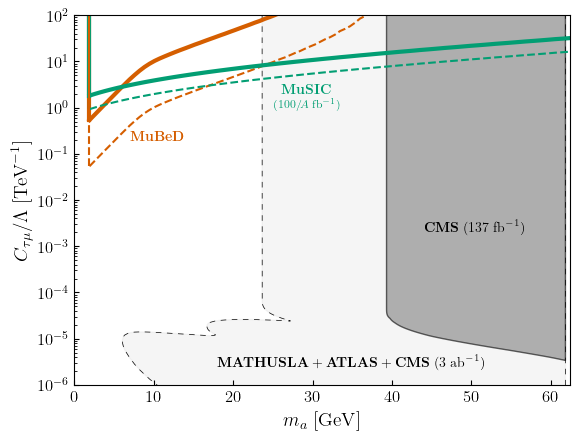

In [11]:
Cll = [[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]]
masses = np.linspace(0, 62.5, 100)
ij = (1, 2)

plot_all_limits(masses, ij, 1, Cll = Cll)

plt.text(26, 2, '${\\bf MuSIC}$', color = colors[2], fontsize = 10)
plt.text(25.1, 1.0, '$(100/A~{\\rm fb}^{-1})$', color = colors[2], fontsize = 8)

plt.text(7, 2e-1, '${\\bf MuBeD}$', color = colors[3], fontsize = 10)

plt.text(44, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 10)
plt.text(18, 2.5e-6, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 10)

plt.axvline(1.777, 0.75, 1, color = colors[2])
plt.axvline(1.777, 0.72, 1, color = colors[3])

plt.ylabel('$C_{\\tau \\mu}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 14)

plt.yscale('log')
plt.ylim(1e-6, 1e2)
plt.xlim(0, 62.5)
#plt.xscale('log')

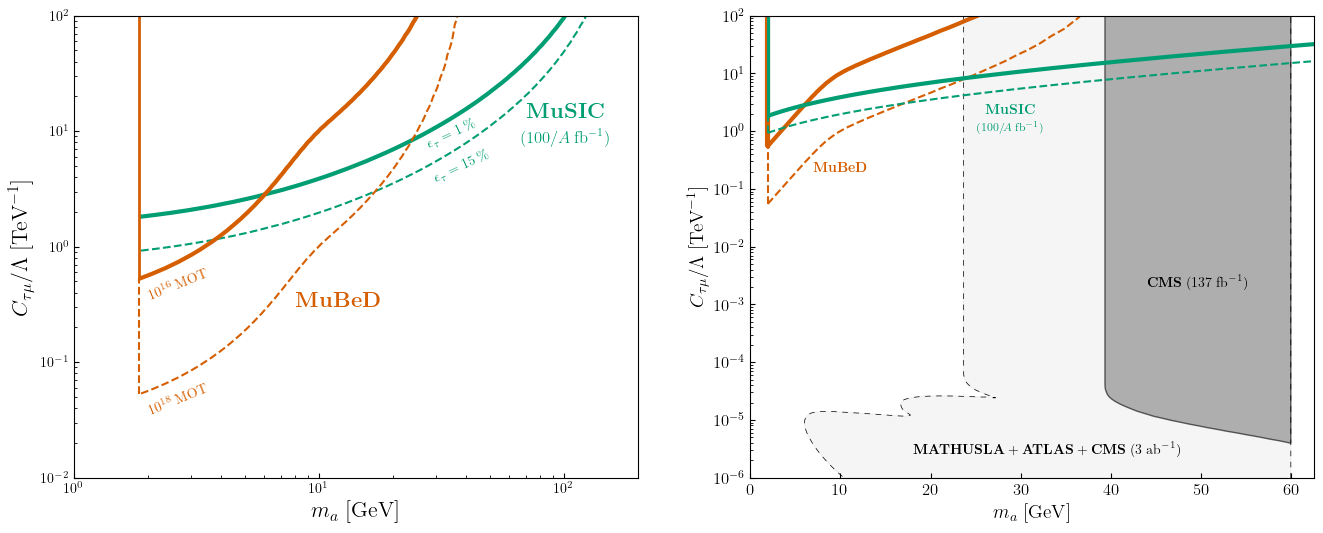

In [31]:
Cll = [[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]]
ij = (1, 2)

masses = np.geomspace(1e0, 200, 1000)

fig = plt.figure(figsize = (16, 6))
gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

plt.plot(masses, 
         MuSIC_limit(masses,
                     g = Cll, 
                     tau_efficiency = 0.01, 
                     ALP = True),
         color = colors[2],
         linewidth = 3)

plt.plot(masses, 
         MuSIC_limit(masses,
                     g = Cll, 
                     tau_efficiency = 0.15, 
                     ALP = True),
         color = colors[2],
         linestyle = 'dashed')


plt.plot(masses, 
         MuBeD_limit(masses,
                     g = Cll, 
                     tau_efficiency = 0.15,
                     ALP = True),
         color = colors[3],
         linewidth = 3)
plt.plot(masses, 
         MuBeD_limit(masses,
                     g = Cll, 
                     tau_efficiency = 0.15,
                     N_MOT = 1e18,
                     ALP = True),
         color = colors[3],
         linestyle = 'dashed')

plt.axvline(mt+mm-0.04, 0.432, 1, color = colors[3], linewidth = 2)
plt.axvline(mt+mm-0.04, 0.18, 0.432, color = colors[3], linestyle = 'dashed')

plt.text(8, 0.3, '${\\bf MuBeD}$', color = colors[3], fontsize = 16)

plt.text(2, 3.5e-1, '$10^{16}~{\\rm MOT}$', rotation = 22, color = colors[3])
plt.text(2, 3.5e-2, '$10^{18}~{\\rm MOT}$', rotation = 22, color = colors[3])


plt.text(70, 13, '${\\bf MuSIC}$', color = colors[2], fontsize = 16)
plt.text(67, 8, '$(100/A~{\\rm fb}^{-1})$', color = colors[2], fontsize = 12)

plt.text(29, 3.6, '$\\epsilon_\\tau = 15~\\%$', rotation = 25, color = colors[2])
plt.text(27, 7, '$\\epsilon_\\tau = 1~\\%$', rotation = 25, color = colors[2])


plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)
plt.ylabel('$C_{\\tau \\mu}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)
plt.tick_params(which = 'both', direction = 'in') 

plt.yscale('log')
plt.ylim(1e-2, 1e2)
plt.xlim(1e0, 200)
plt.xscale('log')


ax2 = fig.add_subplot(gs[1])

masses = np.geomspace(1e0, 62.5, 100)

plot_all_limits(masses, ij, 1, Cll = Cll)

plt.text(26, 2, '${\\bf MuSIC}$', color = colors[2], fontsize = 10)
plt.text(25.1, 1.0, '$(100/A~{\\rm fb}^{-1})$', color = colors[2], fontsize = 8)

plt.text(7, 2e-1, '${\\bf MuBeD}$', color = colors[3], fontsize = 10)

plt.text(44, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 10)
plt.text(18, 2.5e-6, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 10)

plt.axvline(1.777, 0.75, 1, color = colors[2])
plt.axvline(1.777, 0.72, 1, color = colors[3])

plt.ylabel('$C_{\\tau \\mu}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 14)

plt.yscale('log')
plt.ylim(1e-6, 1e2)
plt.xlim(0, 62.5)

plt.savefig('figures/chapter5/MuSIC_MuBeD_ALP_limits.pdf', format = 'pdf')

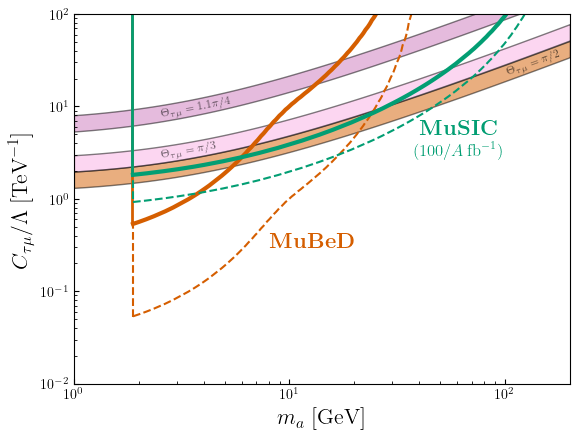

In [32]:
#plot_dipole_limits((0, 2))

Cll = [[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]]
masses = np.geomspace(1e0, 200, 1000)

plt.plot(masses, 
         MuBeD_limit(masses,
                     g = Cll, 
                     tau_efficiency = 0.15,
                     ALP = True),
         color = colors[3],
         linewidth = 3)
plt.plot(masses, 
         MuBeD_limit(masses,
                     g = Cll, 
                     tau_efficiency = 0.15,
                     N_MOT = 1e18,
                     ALP = True),
         color = colors[3],
         linestyle = 'dashed')

plt.axvline(mt+mm-0.01, 0.44, 1, color = colors[3], linewidth = 2)
plt.axvline(mt+mm, 0.18, 0.44, color = colors[3], linestyle = 'dashed')

plt.plot(masses, 
         MuSIC_limit(masses,
                     g = Cll, 
                     tau_efficiency = 0.01, 
                     ALP = True),
         color = colors[2],
         linewidth = 3)

plt.plot(masses, 
         MuSIC_limit(masses,
                     g = Cll, 
                     tau_efficiency = 0.15, 
                     ALP = True),
         color = colors[2],
         linestyle = 'dashed')

plt.axvline(mt+mm-0.01, 0.57, 1, color = colors[2], linewidth = 2)
plt.axvline(mt+mm, 0.5, 0.57, color = colors[2], linestyle = 'dashed')


plt.fill_between(masses, *g_2_explanation(masses, 'mu', (1, 2), th = np.pi/2*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[3], edgecolor = 'black')
plt.fill_between(masses, *g_2_explanation(masses, 'mu', (1, 2), th = np.pi/3*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[6], edgecolor = 'black')
plt.fill_between(masses, *g_2_explanation(masses, 'mu', (1, 2), th = 1.1*np.pi/4*np.ones((3, 3)), ALP = True), alpha = 0.5, color = colors[4], edgecolor = 'black')

plt.text(2.5, 7.7, '$\\Theta_{\\tau \\mu} = 1.1\\pi/4$', rotation = 11, fontsize = 8, alpha = 0.6)
plt.text(2.5, 2.75, '$\\Theta_{\\tau \\mu} = \\pi/3$', rotation = 10, fontsize = 8, alpha = 0.6)
plt.text(100, 22, '$\\Theta_{\\tau \\mu} = \\pi/2$', rotation = 20, fontsize = 8, alpha = 0.6)


plt.text(8, 0.3, '${\\bf MuBeD}$', color = colors[3], fontsize = 16)

plt.text(40, 5, '${\\bf MuSIC}$', color = colors[2], fontsize = 16)
plt.text(38, 3, '$(100/A~{\\rm fb}^{-1})$', color = colors[2], fontsize = 12)



plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)
plt.ylabel('$C_{\\tau \\mu}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)
plt.tick_params(which = 'both', direction = 'in') 



plt.yscale('log')
plt.ylim(1e-2, 1e2)
plt.xlim(1e0, 200)
plt.xscale('log')


plt.savefig('figures/chapter5/MuSIC_MuBeD_ALP_electron_g_2.pdf', format = 'pdf')

In [13]:
Cll = [[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]]

theta = np.linspace(np.pi/4, np.pi/2, 10000)
theta_mat = theta.reshape(1, 1, 1, -1) * np.ones((3, 3, 1, 1))

masses = np.geomspace(1, 200, 1000)

g_mu_explanation = g_2_explanation(masses.reshape(-1, 1), 'mu', (2, 1), g = np.array(Cll).reshape(3, 3, 1, 1).repeat(10000, axis = 3), th = theta_mat, ALP = True)
g_mu_avg = np.mean(g_mu_explanation, axis = 0)

gmt_MuSIC = MuSIC_limit(masses, g = Cll, tau_efficiency = 0.01, ALP = True).reshape(-1, 1)
gmt_MuSIC_opt = MuSIC_limit(masses, g = Cll, tau_efficiency = 0.15, ALP = True).reshape(-1, 1)

gmt_MuBeD = MuBeD_limit(masses, g = Cll, N_MOT = 1e16, ALP = True).reshape(-1, 1)
gmt_MuBeD_opt = MuBeD_limit(masses, g = Cll, N_MOT = 1e18, ALP = True).reshape(-1, 1)

#We want those values of m and theta for which g_explanation > g_EIC_lim

MuSIC_line = find_contours(masses, theta, (g_mu_avg - gmt_MuSIC), 0)[0]
MuBeD_line = find_contours(masses, theta, (g_mu_avg - gmt_MuBeD), 0)[0]

MuSIC_line_opt = find_contours(masses, theta, (g_mu_avg - gmt_MuSIC_opt), 0)[0]
MuBeD_line_opt = find_contours(masses, theta, (g_mu_avg - gmt_MuBeD_opt), 0)[0]

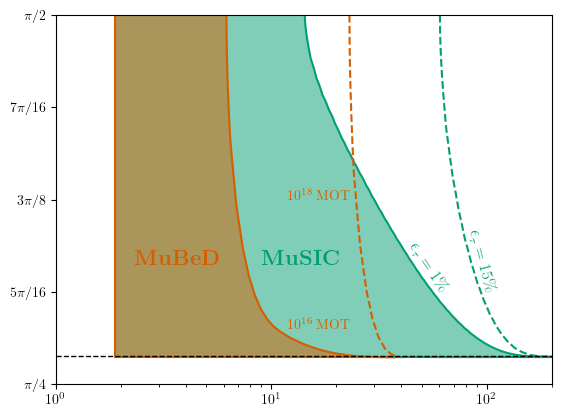

In [33]:

plt.fill_betweenx(*MuSIC_line[::-1], mt+mm, color = colors[2], alpha = 0.5, edgecolor = None)
plt.fill_betweenx(*MuBeD_line[::-1], mt+mm, color = colors[3], alpha = 0.5, edgecolor = None)

plt.plot(*MuSIC_line, color = colors[2])
plt.plot(*MuBeD_line, color = colors[3])

plt.plot(*MuSIC_line_opt, color = colors[2], linestyle = 'dashed')
plt.plot(*MuBeD_line_opt, color = colors[3], linestyle = 'dashed')

plt.axvline(mt+mm, 0.076, color = colors[3])
plt.axhline(np.pi/4+mm/mt-0.001, 0.12, color = colors[3])
plt.axhline(np.pi/4+mm/mt-0.001, 0.68, color = colors[2])


plt.text(42, 5*np.pi/16, '$\\epsilon_\\tau = 1\%$', rotation = -56, fontsize = 12, color = colors[2])
plt.text(80, 5*np.pi/16, '$\\epsilon_\\tau = 15\%$', rotation = -75, fontsize = 12, color = colors[2])

plt.text(12, 3*np.pi/8, '$10^{18}~{\\rm MOT}$', color = colors[3])
plt.text(12, 4.6*np.pi/16, '$10^{16}~{\\rm MOT}$', color = colors[3])

plt.text(2.3, 5.3*np.pi/16, '${\\bf MuBeD}$', color = colors[3], fontsize = 16)
plt.text(9, 5.3*np.pi/16, '${\\bf MuSIC}$', color = colors[2], fontsize = 16)

plt.yticks([np.pi/4, 5*np.pi/16, 3*np.pi/8, 7*np.pi/16, np.pi/2],
           ['$\\pi/4$','$5\\pi/16$', '$3\\pi/8$', '$7\\pi/16$', '$\\pi/2$'])
plt.axhline(np.pi/4 + mm/mt, linestyle = 'dashed', linewidth = 1, color = 'black')


plt.ylim(np.pi/4, np.pi/2)
plt.xlim(1e0, 200)
plt.xscale('log')

plt.savefig('figures/chapter5/MuSIC_MuBeD_g_2_probe.pdf', format = 'pdf')